In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import statsmodels.api as sm

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
# Make a copy of train and test data

train_original = train.copy()
test_original = test.copy()

In [4]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [5]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [6]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [7]:
train['Datetime'] = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')

test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')

train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format = '%d-%m-%Y %H:%M')

test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format = '%d-%m-%Y %H:%M')

In [8]:
for i in (train, test, train_original, test_original):
    i['Year'] = i.Datetime.dt.year
    i['Month'] = i.Datetime.dt.month
    i['Day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour

In [9]:
train['Day of Week'] = train['Datetime'].dt.dayofweek

temp = train['Datetime']

In [10]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

In [11]:
temp2 = train['Datetime'].apply(applyer)
train['Weekend'] = temp2

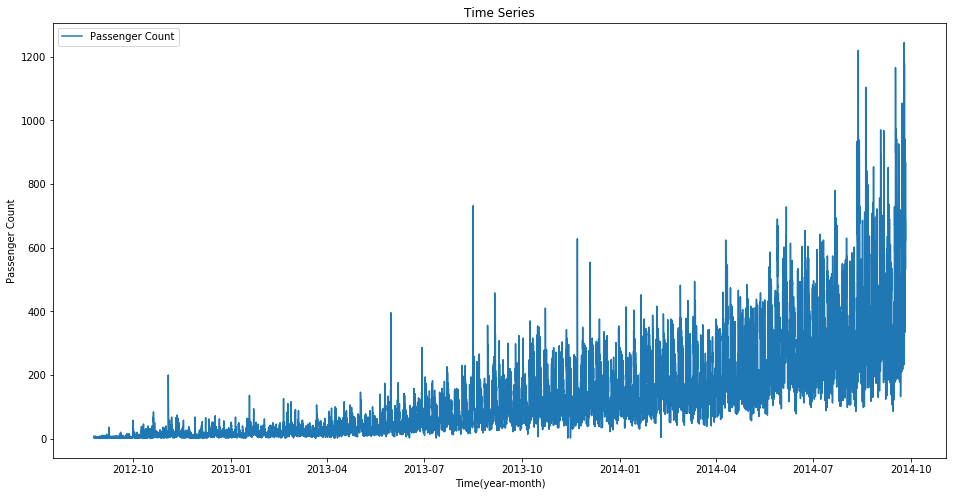

In [12]:
# Indexing the datetime to get the time period on the x-axis

train.index = train['Datetime']

# Drop ID variable to get only the datetime on x-axis

df = train.drop('ID', axis = 1)

ts = df['Count']

plt.figure(figsize = (16, 8))
plt.plot(ts, label = 'Passenger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc = 'best')

### Exploratory Data Analysis

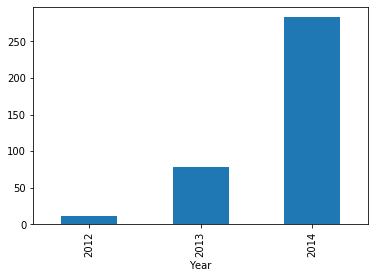

In [13]:
# Hyp 1 -> Traffic will increase as the years pass by

yoy = train.groupby('Year')['Count'].mean().plot.bar()

# An exponential growth in the traffic over year
# can validate hypothesis 1

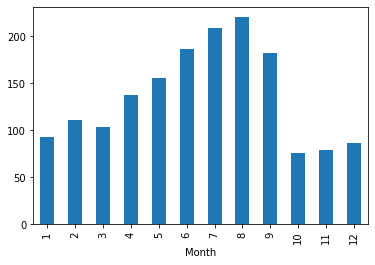

In [14]:
train.groupby('Month')['Count'].mean().plot.bar()

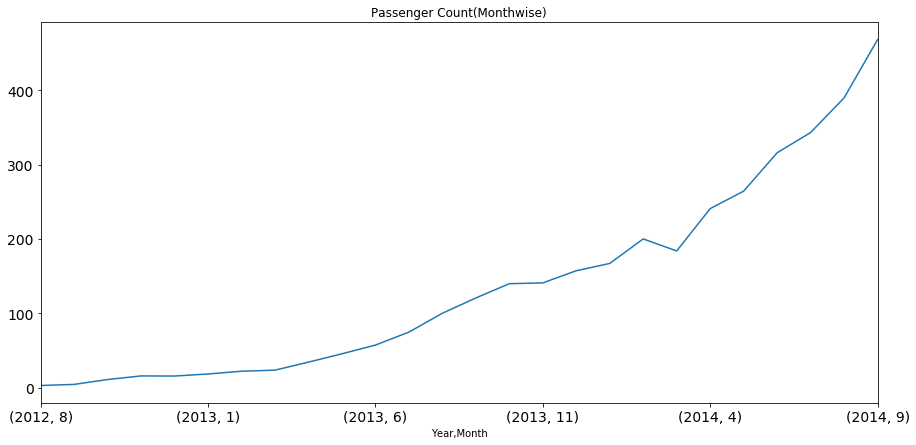

In [15]:
# Monthly mean of each year

temp = train.groupby(['Year', 'Month'])['Count'].mean()
temp.plot(figsize = (15, 7), title = 'Passenger Count(Monthwise)', fontsize = 14)

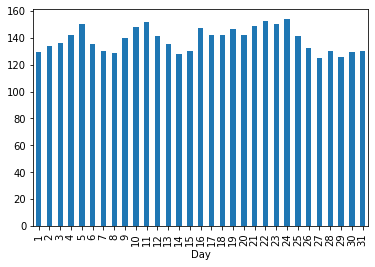

In [16]:
# Daily mean of passenger count

train.groupby('Day')['Count'].mean().plot.bar()

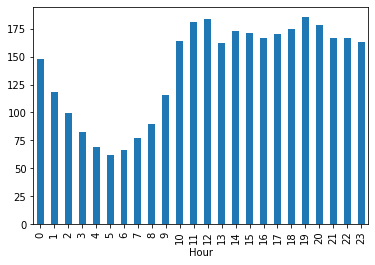

In [17]:
# Hourly mean of passenger count

train.groupby('Hour')['Count'].mean().plot.bar()

# The peak traffic start at 7PM and then decreasing trend untill 5 PM
# maximum peak is between 11 AM and 12 AM noon.

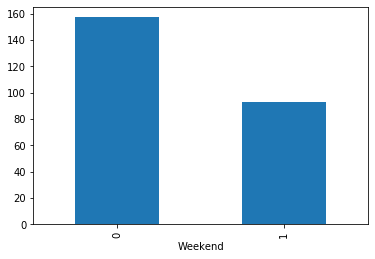

In [18]:
# Weekday vs Weekend passenger count

train.groupby('Weekend')['Count'].mean().plot.bar()

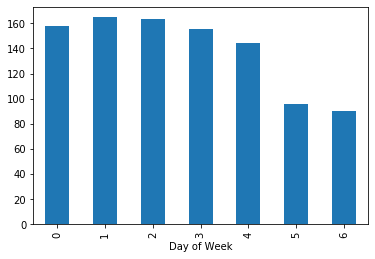

In [19]:
# Day wise passenger count

train.groupby('Day of Week')['Count'].mean().plot.bar()

In [20]:
train = train.drop('ID', axis = 1)

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')

train.index = train.Timestamp

# Hourly time series

hourly = train.resample('H').mean()

# Daily time series

daily = train.resample('D').mean()

# Weekly time series

weekly = train.resample('W').mean()

# Monthly time series

monthly = train.resample('M').mean()

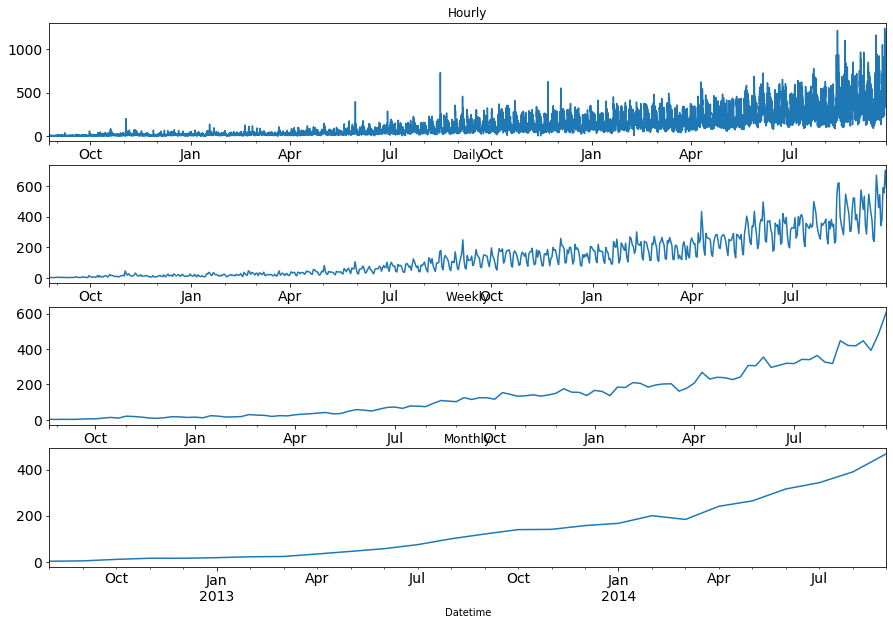

In [22]:
fig, ax = plt.subplots(4, 1)
hourly.Count.plot(figsize = (15, 10), title = 'Hourly', fontsize = 14, ax = ax[0])
daily.Count.plot(figsize = (15, 10), title = 'Daily', fontsize = 14, ax = ax[1])
weekly.Count.plot(figsize = (15, 10), title = 'Weekly', fontsize = 14, ax = ax[2])
monthly.Count.plot(figsize = (15, 10), title = 'Monthly', fontsize = 14, ax = ax[3])

In [23]:
test.Timestamp = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')

test.index = test.Timestamp

# Convert to daily mean

test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')

train.index = train.Timestamp

# Convert to daily mean

train = train.resample('D').mean()

### Splitting the data (Training and Validation)

In [24]:
Train = train.ix['2012-08-25':'2014-06-24']
valid = train.ix['2014-06-25':'2014-09-25']

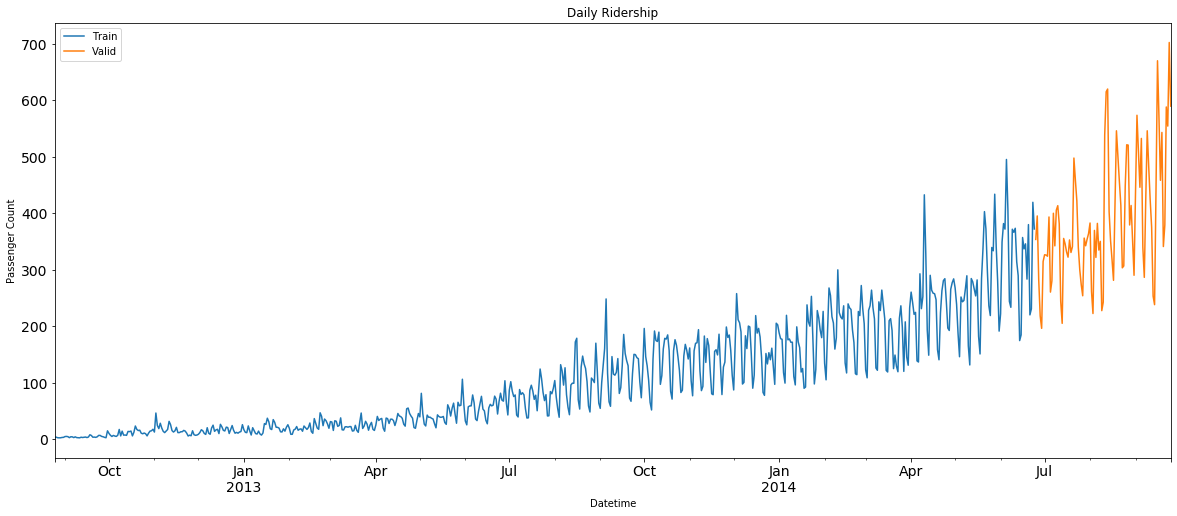

In [25]:
Train.Count.plot(figsize = (20, 8), title = 'Daily Ridership', fontsize = 14, label = 'Train')
valid.Count.plot(figsize = (20, 8), title = 'Daily Ridership', fontsize = 14, label = 'Valid')

plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.legend(loc = 2)
plt.show()

### Modelling Techniques

1. Naive Approach
2. Moving Average
3. Simple Exponential Smoothing
4. Holt's Linear Trend Model
5. Holt's Winter Model

#### Naive Approach

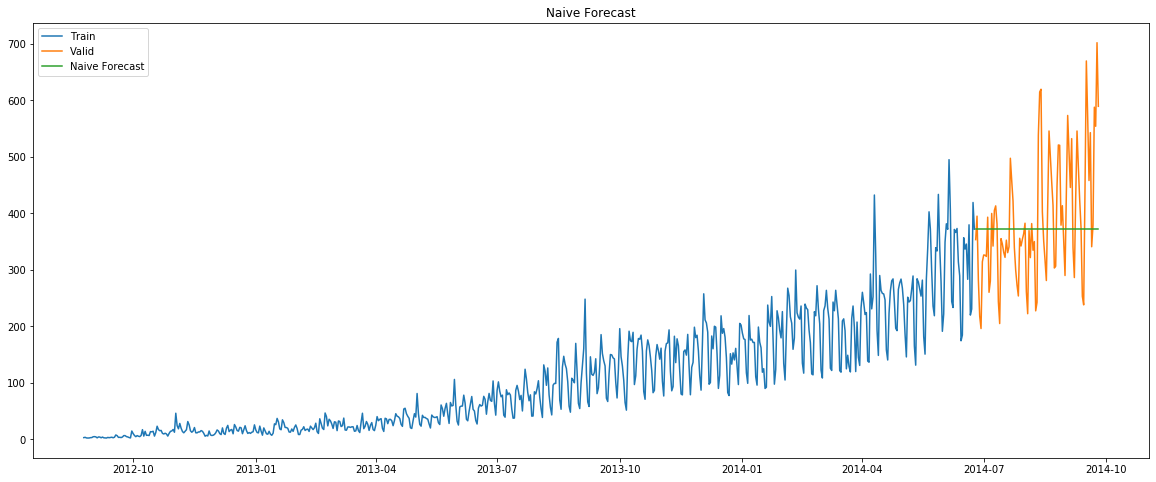

In [26]:
dd = np.asarray(Train.Count)

y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]

plt.figure(figsize = (20, 8))
plt.plot(Train.index, Train['Count'], label = 'Train')
plt.plot(valid.index, valid['Count'], label = 'Valid')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')

plt.legend(loc = 'best')
plt.title('Naive Forecast')
plt.show()

#### RMSE Naive Approach

In [27]:
rmse = sqrt(mean_squared_error(valid['Count'], y_hat['naive']))

print('RMSE Naive Forecast : {}'.format(rmse))

RMSE Naive Forecast : 111.79050467496724


#### Moving Average Forecast

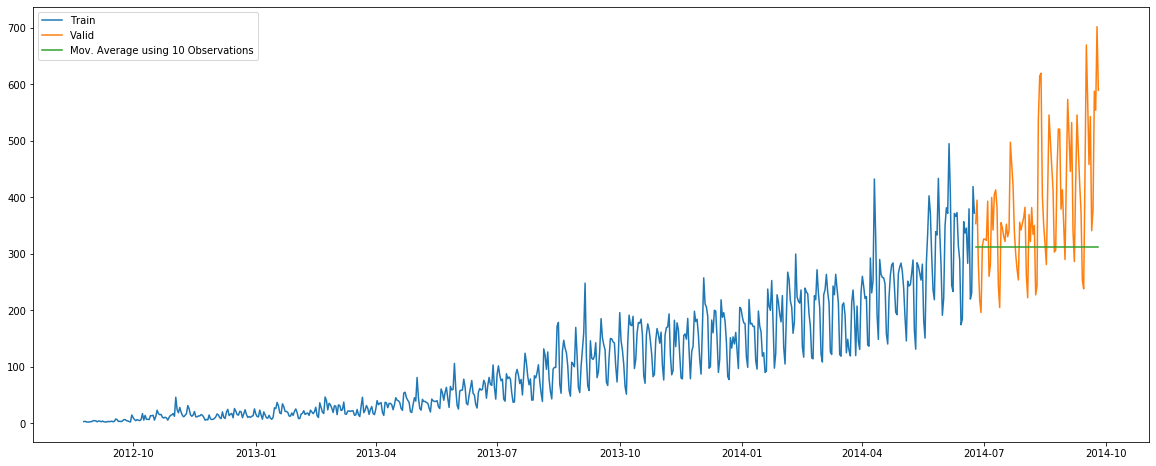

In [28]:
y_hat_avg = valid.copy()
y_hat_avg['Moving_avg_forecast_10'] = Train['Count'].rolling(10).mean().iloc[-1]
plt.figure(figsize = (20, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Moving_avg_forecast_10'], label = 'Mov. Average using 10 Observations')
plt.legend(loc = 'best')
plt.show()

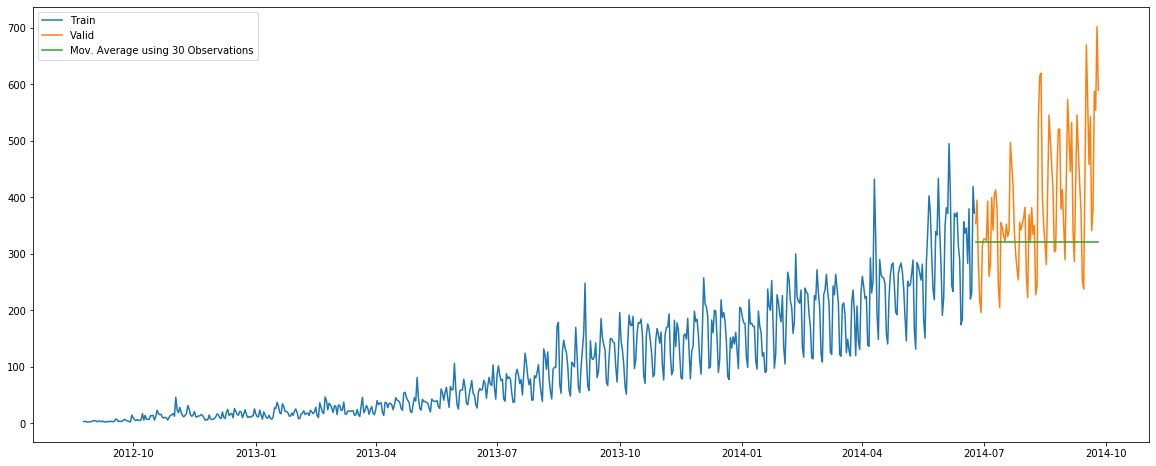

In [29]:
y_hat_avg['Moving_avg_forecast_30'] = Train['Count'].rolling(30).mean().iloc[-1]
plt.figure(figsize = (20, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Moving_avg_forecast_30'], label = 'Mov. Average using 30 Observations')
plt.legend(loc = 'best')
plt.show()

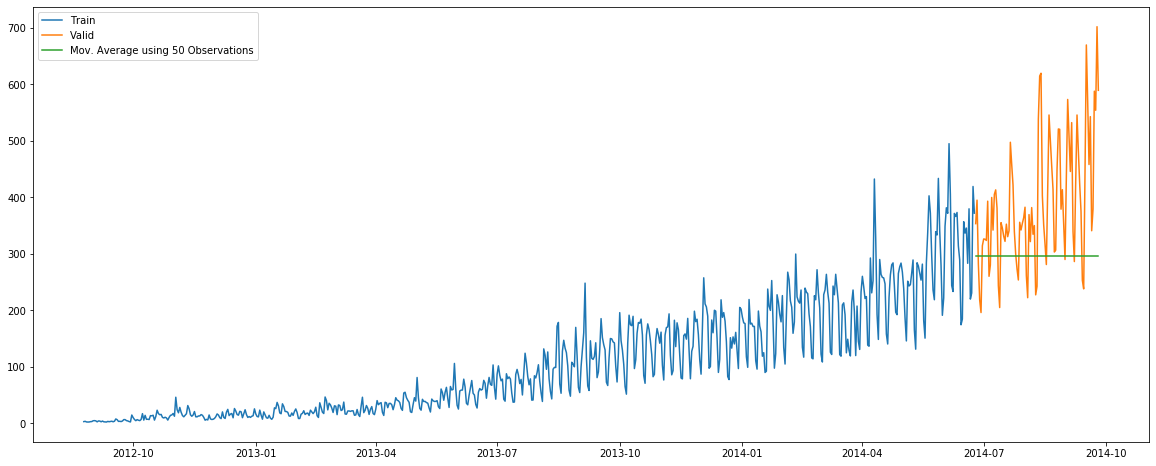

In [30]:
y_hat_avg['Moving_avg_forecast_50'] = Train['Count'].rolling(50).mean().iloc[-1]
plt.figure(figsize = (20, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Moving_avg_forecast_50'], label = 'Mov. Average using 50 Observations')
plt.legend(loc = 'best')
plt.show()

#### RMSE Moving Average Forecast

In [31]:
rmse_10 = sqrt(mean_squared_error(valid['Count'], y_hat_avg['Moving_avg_forecast_10']))
rmse_30 = sqrt(mean_squared_error(valid['Count'], y_hat_avg['Moving_avg_forecast_30']))
rmse_50 = sqrt(mean_squared_error(valid['Count'], y_hat_avg['Moving_avg_forecast_50']))

print('RMSE Mov. Average 10 Observations : {}'.format(rmse_10))
print('RMSE Mov. Average 30 Observations : {}'.format(rmse_30))
print('RMSE Mov. Average 50 Observations : {}'.format(rmse_50))

RMSE Mov. Average 10 Observations : 134.23733308950264
RMSE Mov. Average 30 Observations : 129.6495809983456
RMSE Mov. Average 50 Observations : 144.19175679986802


#### Simple Exponential Smoothing

In [32]:
# Build and Fitting model

ExpSmooth_model = SimpleExpSmoothing(np.asarray(Train['Count']))
fit_model = ExpSmooth_model.fit(smoothing_level = 0.6, optimized = False)

In [33]:
# Forecast

y_hat_avg['SES'] = fit_model.forecast(len(valid))

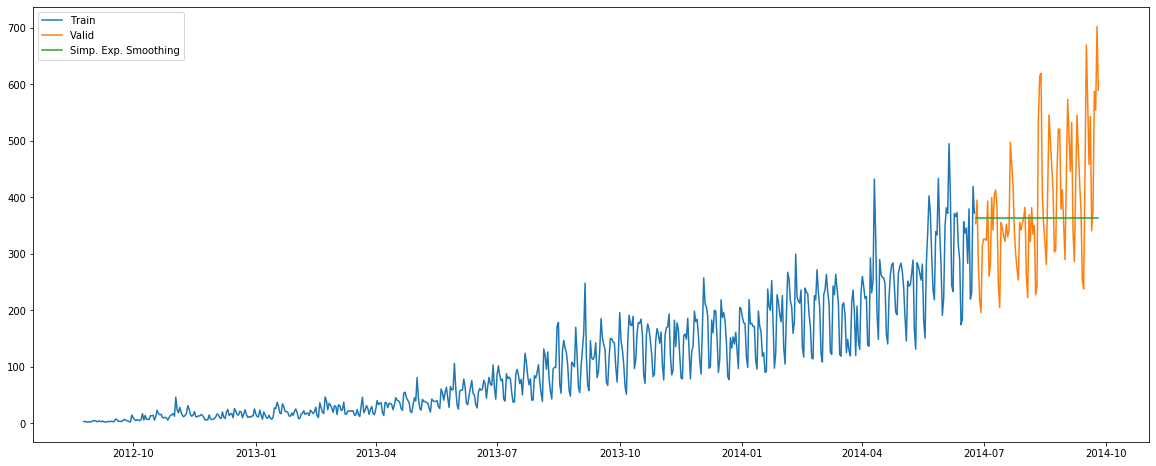

In [34]:
plt.figure(figsize = (20, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['SES'], label = 'Simp. Exp. Smoothing')
plt.legend(loc = 'best')
plt.show()

#### RMSE Simple Exponential Smoothing

In [35]:
rms_SES = sqrt(mean_squared_error(valid['Count'], y_hat_avg['SES']))

print('RMSE Simple Exponential Smoothing : {}'.format(rms_SES))

RMSE Simple Exponential Smoothing : 113.43708111884514


#### Holt's Linear Trend Model

<Figure size 1440x576 with 0 Axes>

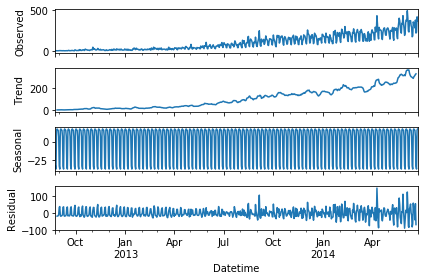

In [36]:
plt.figure(figsize = (20, 8))
sm.tsa.seasonal_decompose(Train['Count']).plot()

result = sm.tsa.stattools.adfuller(train['Count'])
plt.show()

In [37]:
holt_model = Holt(np.asarray(Train['Count']))
fit_holt_model = holt_model.fit(smoothing_level = 0.3, smoothing_slope = 0.1)

In [38]:
y_hat_avg['Holt_Model'] = fit_holt_model.forecast(len(valid))

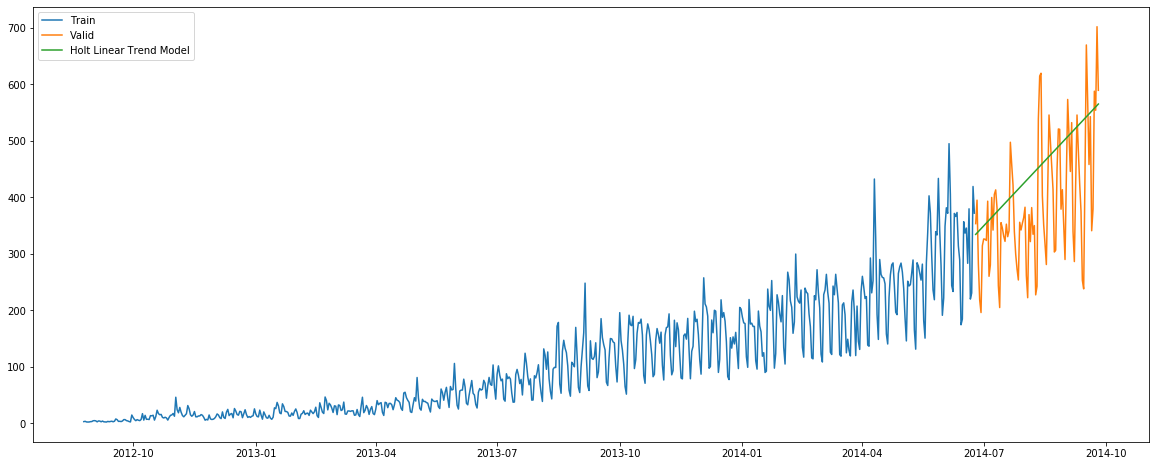

In [39]:
plt.figure(figsize = (20, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Holt_Model'], label = 'Holt Linear Trend Model')
plt.legend(loc = 'best')
plt.show()

#### RMSE Holt Linear Trend Model

In [40]:
rms_holt = sqrt(mean_squared_error(valid['Count'], y_hat_avg['Holt_Model']))

print('RMSE Holt Linear Trend Model : {}'.format(rms_holt))

RMSE Holt Linear Trend Model : 112.94278345314041


In [41]:
predict = fit_holt_model.forecast(len(test))

In [42]:
test['prediction'] = predict

In [43]:
# Calculate the hourly ration of count

train_original['ratio'] = train_original['Count']/train_original['Count'].sum()

In [44]:
# Grouping the hourly ratio

temp = train_original.groupby(['Hour'])['ratio'].sum()

In [45]:
# Export groupby to csv format

pd.DataFrame(temp, columns = ['Hour', 'ratio']).to_csv('GROUPby.csv')

temp2 = pd.read_csv('GROUPby.csv')
temp2 = temp2.drop('Hour.1', 1)

In [46]:
# Merging Test and test_original on day, month and year

merge = pd.merge(test, test_original, on = ('Day', 'Month', 'Year'), how = 'left')
merge['Hour'] = merge['Hour_y']

merge = merge.drop(['Year', 'Month', 'Datetime', 'Hour_x', 'Hour_y'], axis = 1)

In [47]:
# Predict by merging, merge and temp2

prediction = pd.merge(merge, temp2, on = 'Hour', how = 'left')

In [48]:
# Converting the ratio to the original scale

prediction['Count'] = prediction['prediction']*prediction['ratio']*24
prediction['ID'] = prediction['ID_y']

In [49]:
# load submission file

submission = pd.read_csv('submission.csv')

In [50]:
submission = prediction.drop(['ID_x', 
                              'Day', 
                              'ID_y', 
                              'prediction', 
                              'Hour', 
                              'ratio'], axis = 1)

# Converting the final submission to csv format

pd.DataFrame(submission, columns = ['ID', 'Count']).to_csv('Holt Linear.csv')

#### Holt Winter's Model on daily time series

In [51]:
fit_model = ExponentialSmoothing(np.asarray(Train['Count']), 
                                seasonal_periods = 7, 
                                trend = 'add',
                                seasonal = 'add')

In [52]:
holt_winter_model = fit_model.fit()

In [53]:
y_hat_avg['Holt_Winter'] = holt_winter_model.forecast(len(valid))

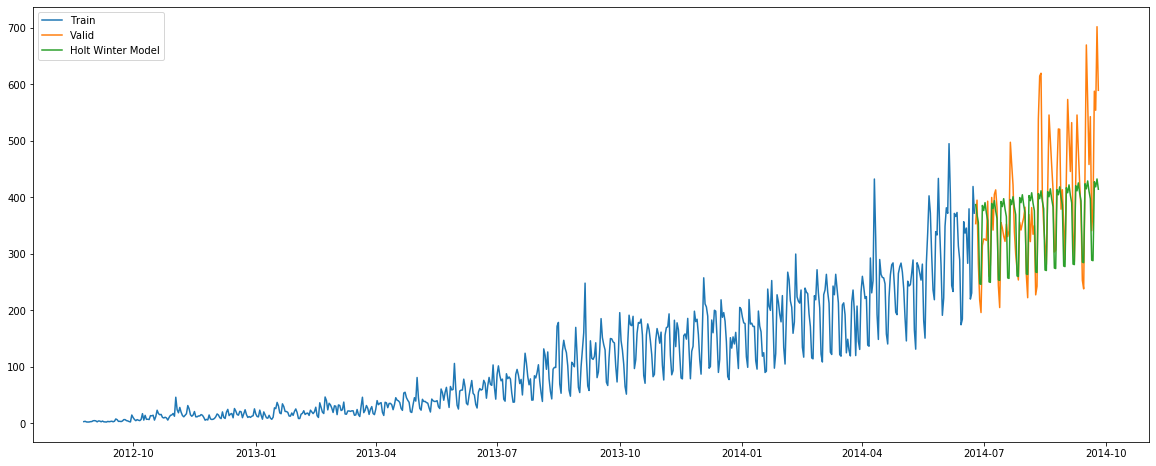

In [54]:
plt.figure(figsize = (20, 8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Holt_Winter'], label = 'Holt Winter Model')
plt.legend(loc = 'best')
plt.show()

In [55]:
rms_holt_winter = sqrt(mean_squared_error(valid['Count'], y_hat_avg['Holt_Winter']))


print('RMSE Holt Winter"s Model : {}'.format(rms_holt_winter))

RMSE Holt Winter"s Model : 82.38041226792582


In [56]:
# Forecast the Counts fot the entire length of the Test dataset

predict_entire = holt_winter_model.forecast(len(test))

In [57]:
test['prediction'] = predict_entire

In [58]:
# Merge Test and test_original on day, month and year

merge = pd.merge(test, test_original, on = ('Day', 'Month', 'Year'), how = 'left')
merge['Hour'] = merge['Hour_y']
merge = merge.drop(['Year', 'Month', 'Datetime', 'Hour_x', 'Hour_y'], axis = 1)

In [59]:
# Predicting by merging merge and temp2

prediction = pd.merge(merge, temp2, on = 'Hour', how = 'left')

In [60]:
# Convert ratio to original scale

prediction['Count'] = prediction['prediction']*prediction['ratio']*24

In [61]:
# Drop all features other than ID and Count

prediction['ID'] = prediction['ID_y']
submission = prediction.drop(['Day', 'Hour', 'ratio', 
                              'prediction', 'ID_x', 
                              'ID_y'], axis = 1)

In [62]:
# Converting the final submission to csv format

pd.DataFrame(submission, columns = ['ID', 'Count']).to_csv('Holt Winter.csv')

### ARIMA

#### Stationary Check

In [63]:
# Making a function to calculate the results of dickey-fuller test

def test_stationarity(time_series):
    
    # Determining rolling statistics
    rol_mean = time_series.rolling(24).mean() # --> 24hours/day
    rol_std = time_series.rolling(24).std()
    
    # Plot rolling statistics
    ori = plt.plot(time_series, color = 'black', label = 'Original')
    mean = plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rol_std, color = 'yellow', label = 'Rolling Std')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    # Performing Dickey-Fuller test
    print('Results of Dickey-Fuller Test :')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic',
                                               'P-Value',
                                               '# Lags Used',
                                               'Number of Observations Used'])
    
    # Critical value from Dickey-Fuller test
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    # Result DF of Dickey-Fuller test
    print(dfoutput)

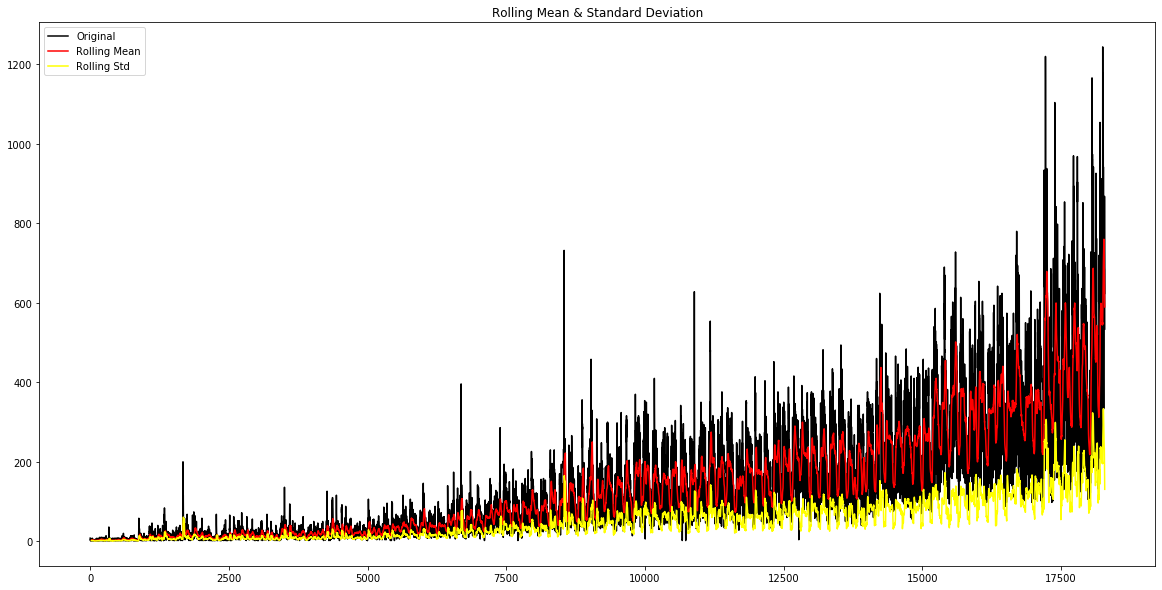

Results of Dickey-Fuller Test :
Test Statistic                    -4.456561
P-Value                            0.000235
# Lags Used                       45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [64]:
rcParams['figure.figsize'] = 20,10

test_stationarity(train_original['Count'])

<b>From the results we can see the time series is stationary, because Test Statistic is lower than Critical Value.

But from the plot there is an increasing trend in the time series data.

#### Remove The Trend

In [65]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

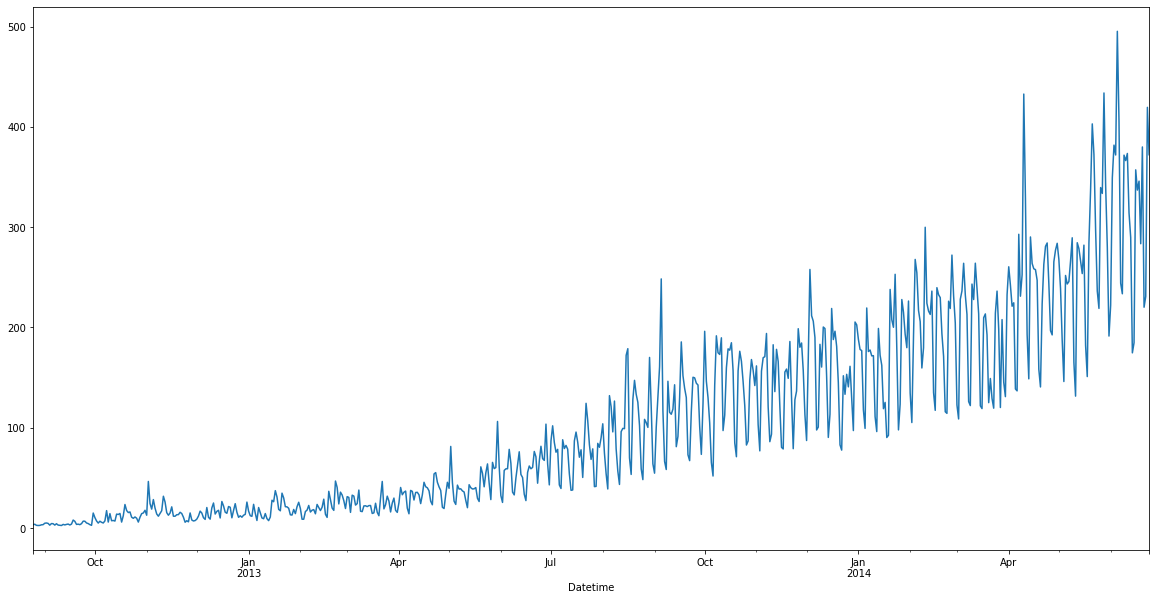

In [66]:
# Data plotting before transformed with log algorithm (simple algorithm)

Train['Count'].plot()

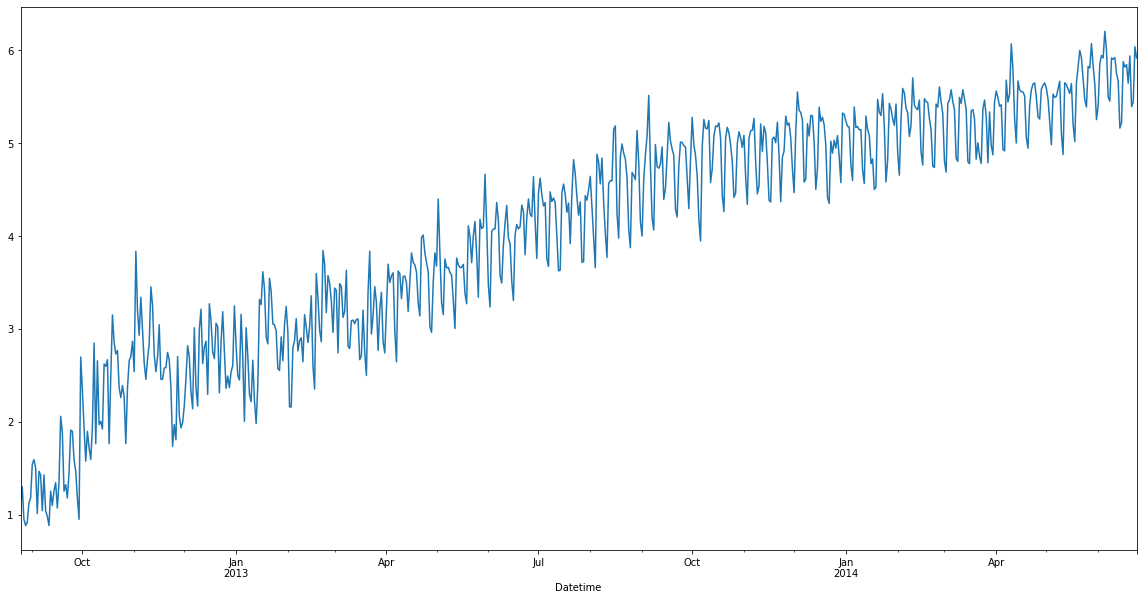

In [67]:
# Data plotting after transformed with log algorithm (simple algorithm)

Train_log.plot()

In [68]:
moving_average = Train_log.rolling(24).mean()

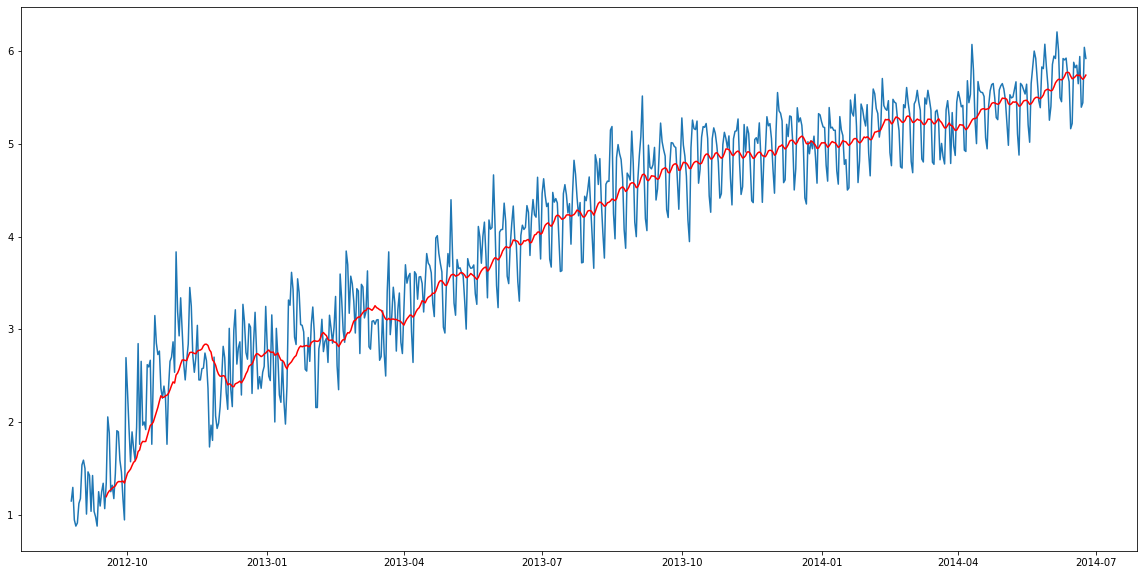

In [69]:
plt.plot(Train_log)
plt.plot(moving_average, color = 'red')
plt.show()

In [70]:
# Remove increasing trend to make stationary time series

train_log_moving_avg_diff = Train_log - moving_average

In [71]:
train_log_moving_avg_diff.dropna(inplace = True)

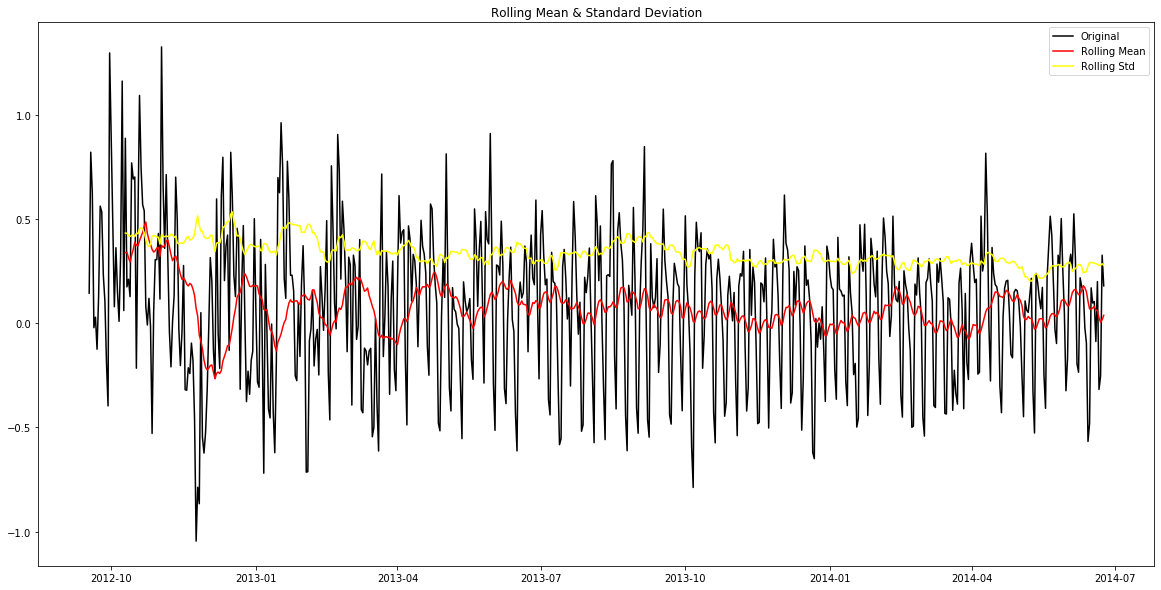

Results of Dickey-Fuller Test :
Test Statistic                -5.861646e+00
P-Value                        3.399422e-07
# Lags Used                    2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [72]:
test_stationarity(train_log_moving_avg_diff)

<b> From the result above, we can see test statistic score became smaller compared to the critical value.

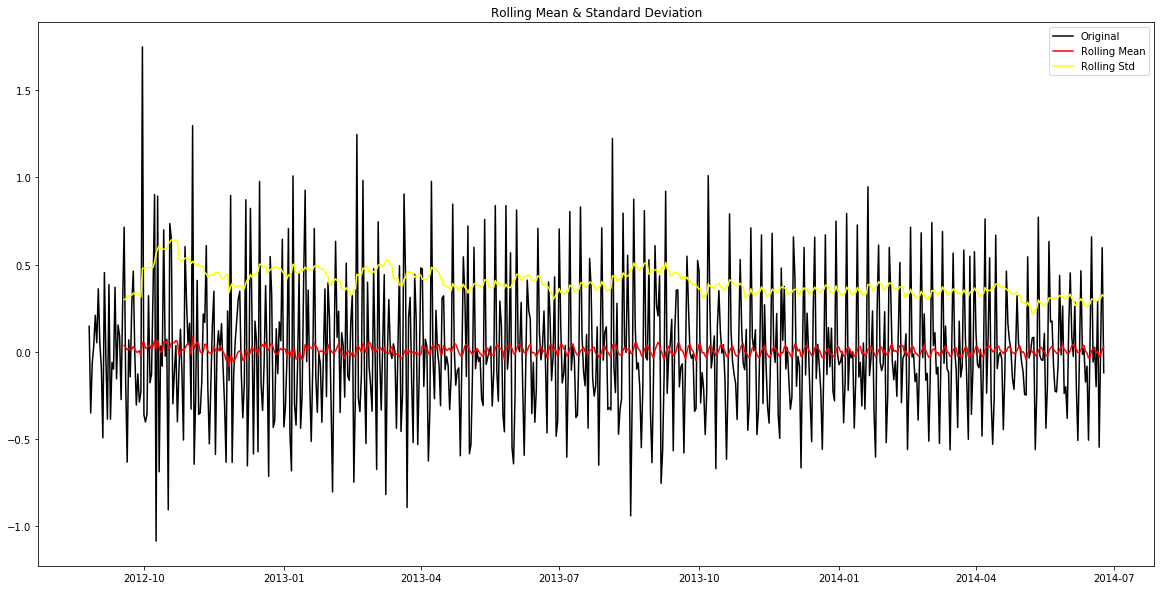

Results of Dickey-Fuller Test :
Test Statistic                -8.237568e+00
P-Value                        5.834049e-13
# Lags Used                    1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [73]:
# Stabilize the mean of time series

train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

<b> By differencing the data, the time series became stable. So the test statistic score became smaller than before.

#### Remove The Seasonality

<b> Seasonality mean periodic fluctuations. A seasonal pattern exists
    when a series is influenced by seasonal factors (quarter of the year, the month or day of the week).

In [74]:
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)

In [75]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

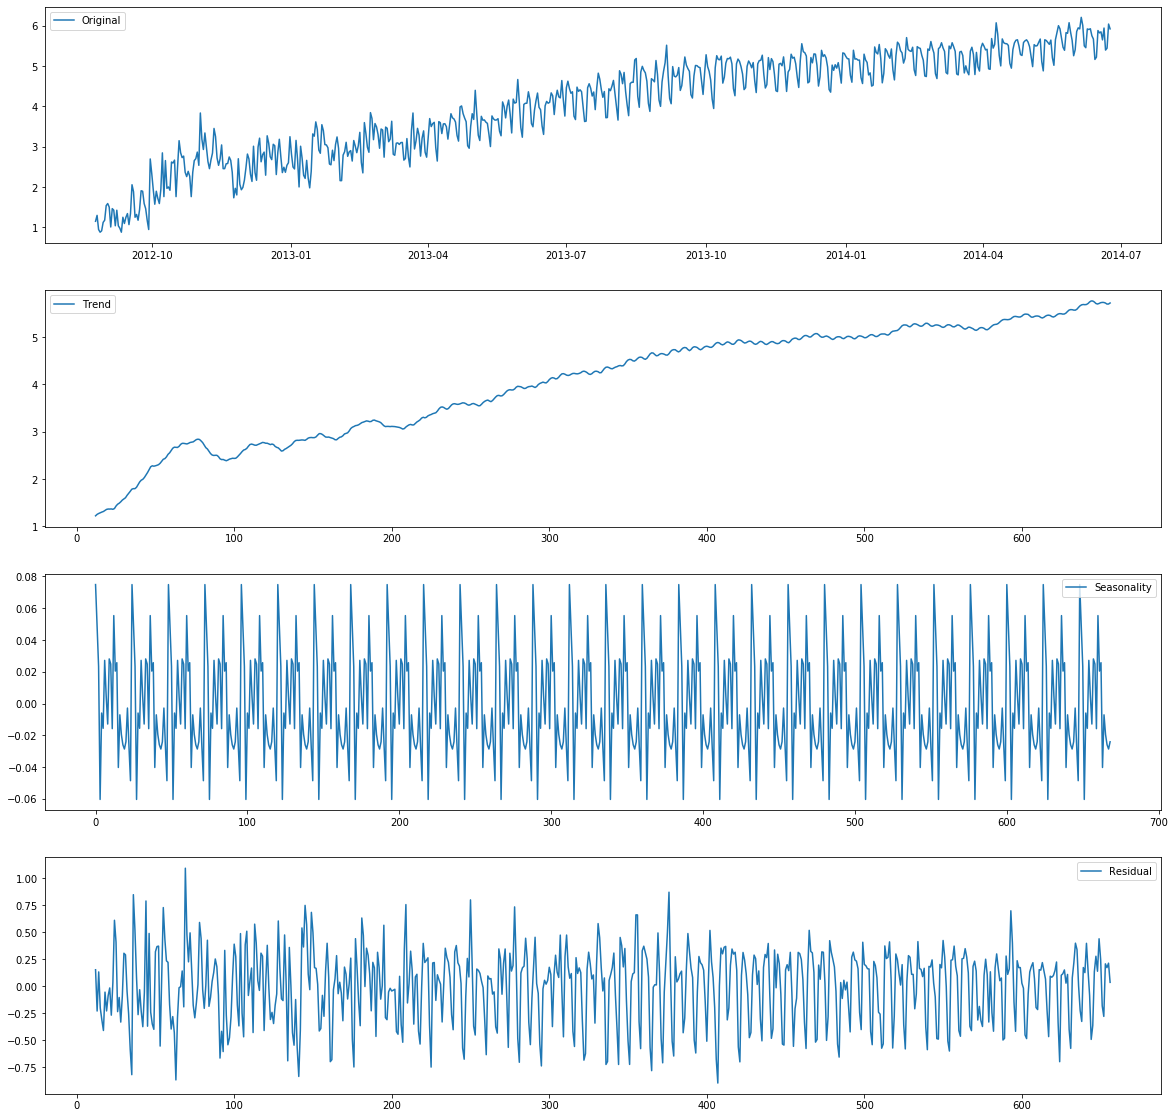

In [76]:
plt.figure(figsize = (20, 20))
plt.subplot(411)
plt.plot(Train_log, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

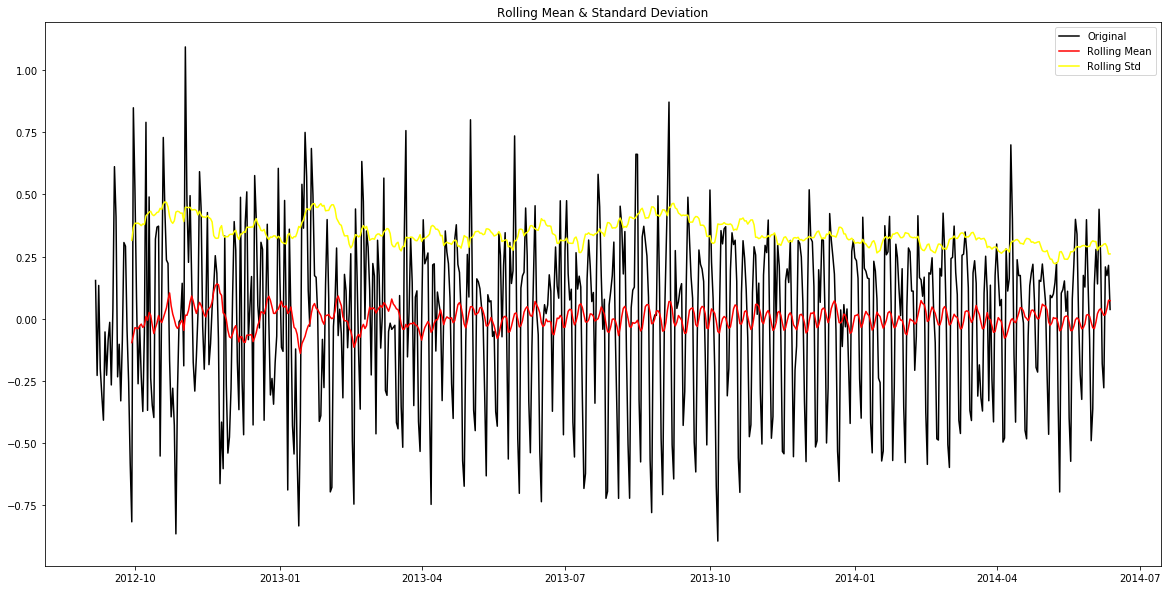

Results of Dickey-Fuller Test :
Test Statistic                -7.822096e+00
P-Value                        6.628321e-12
# Lags Used                    2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [77]:
# Check the stationarity of residuals

plt.figure(figsize = (20, 10))
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace = True)
test_stationarity(train_log_decompose[0])

<b> From the result above, we can see the residuals are stationary.

#### Forecasting Using ARIMA

<b> Finding optimized values for the p, d, q parameters using ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)

In [78]:
lag_acf = acf(train_log_diff.dropna(), nlags = 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method = 'ols')

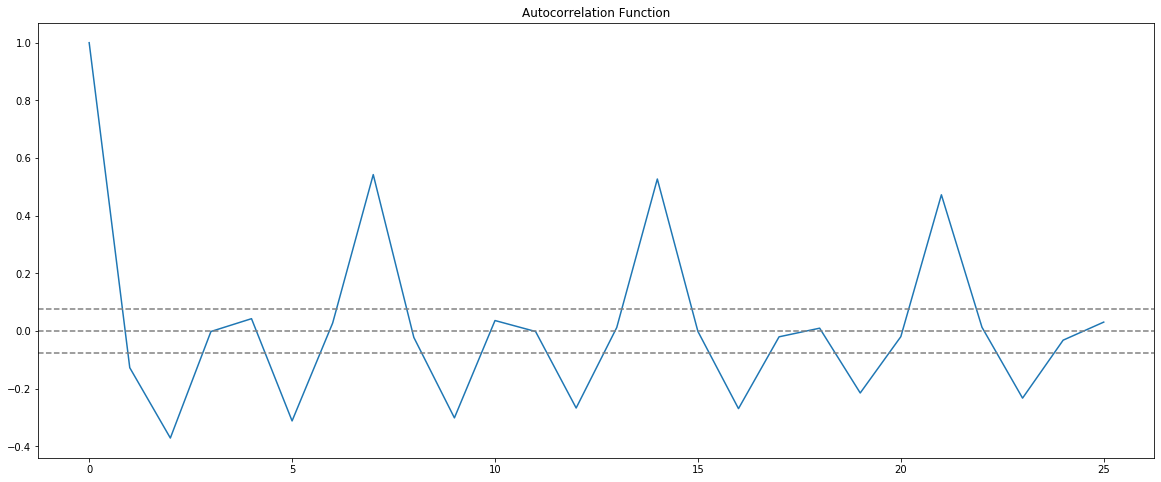

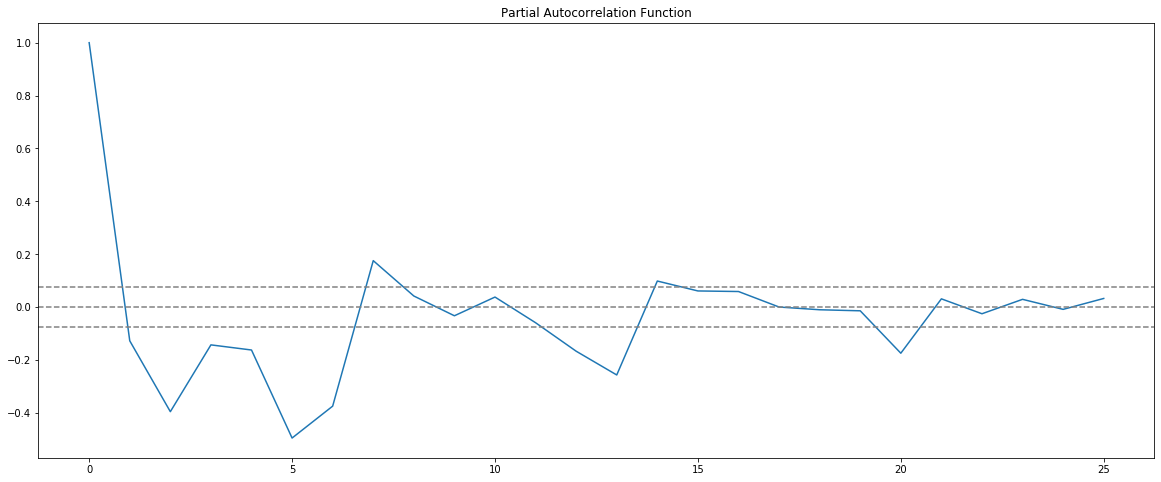

In [79]:
# Plotting ACF and PACF

plt.figure(figsize = (20, 8))
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96 / np.sqrt(len(train_log_diff.dropna())), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96 / np.sqrt(len(train_log_diff.dropna())), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize = (20, 8))
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96 / np.sqrt(len(train_log_diff.dropna())), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96 / np.sqrt(len(train_log_diff.dropna())), linestyle = '--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.show()

#### AR MODEL

In [80]:
# q value is 0 because this is AR model

AR_model = ARIMA(Train_log, order = (2, 1, 0))
results_AR = AR_model.fit(disp = -1)

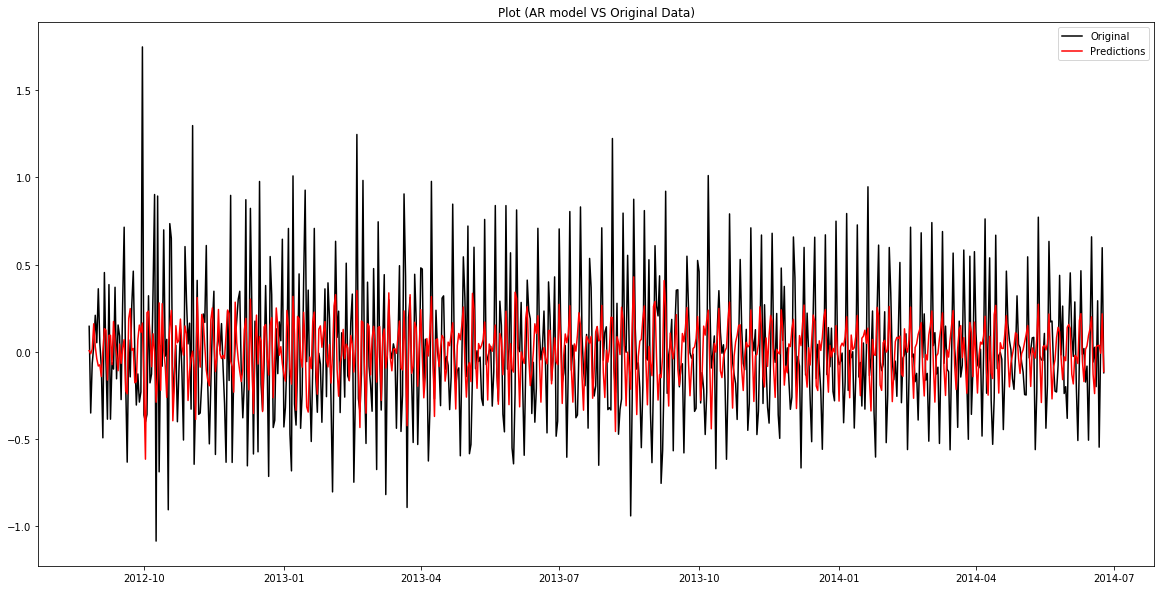

In [81]:
plt.figure(figsize = (20, 10))
plt.plot(train_log_diff.dropna(), color = 'black', label = 'Original')
plt.plot(results_AR.fittedvalues, color = 'red', label = 'Predictions')
plt.legend(loc = 'best')
plt.title('Plot (AR model VS Original Data)')
plt.show()

#### MA Model

In [82]:
# p value is 0 because this is MA model

MA_model = ARIMA(Train_log, order = (0, 1, 2))

In [83]:
results_MA = MA_model.fit(disp = -1)

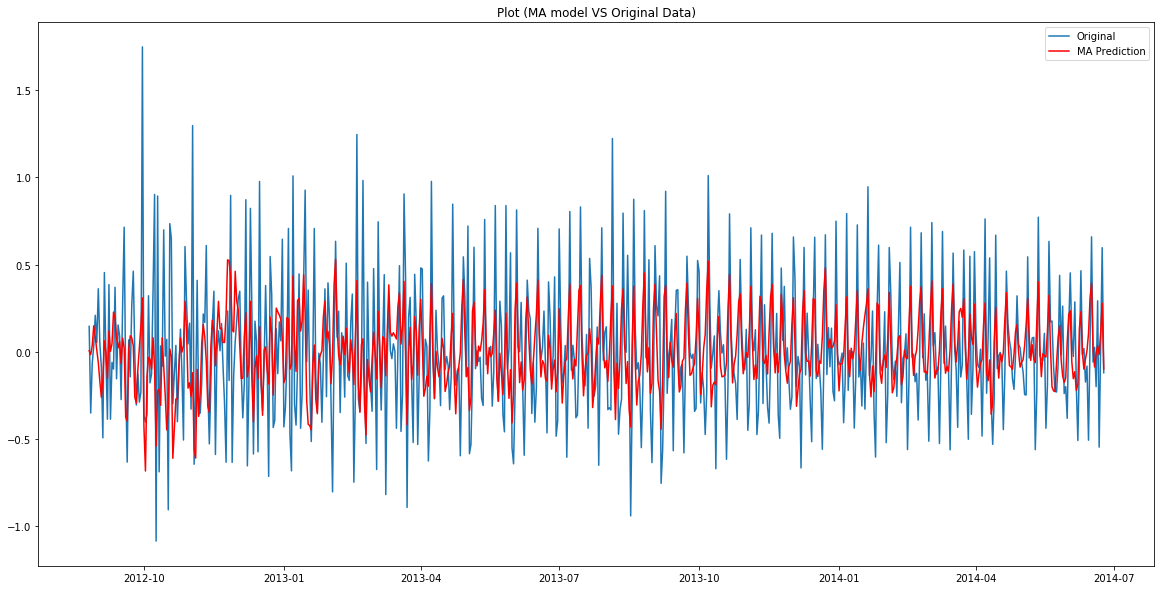

In [84]:
plt.figure(figsize = (20, 10))
plt.plot(train_log_diff.dropna(), label = 'Original')
plt.plot(results_MA.fittedvalues, color = 'red', label = "MA Prediction")
plt.legend(loc = 'best')
plt.title('Plot (MA model VS Original Data)')
plt.show()

### ARIMA Comparison

#### Original VS AR VS MA Comparison Plotting

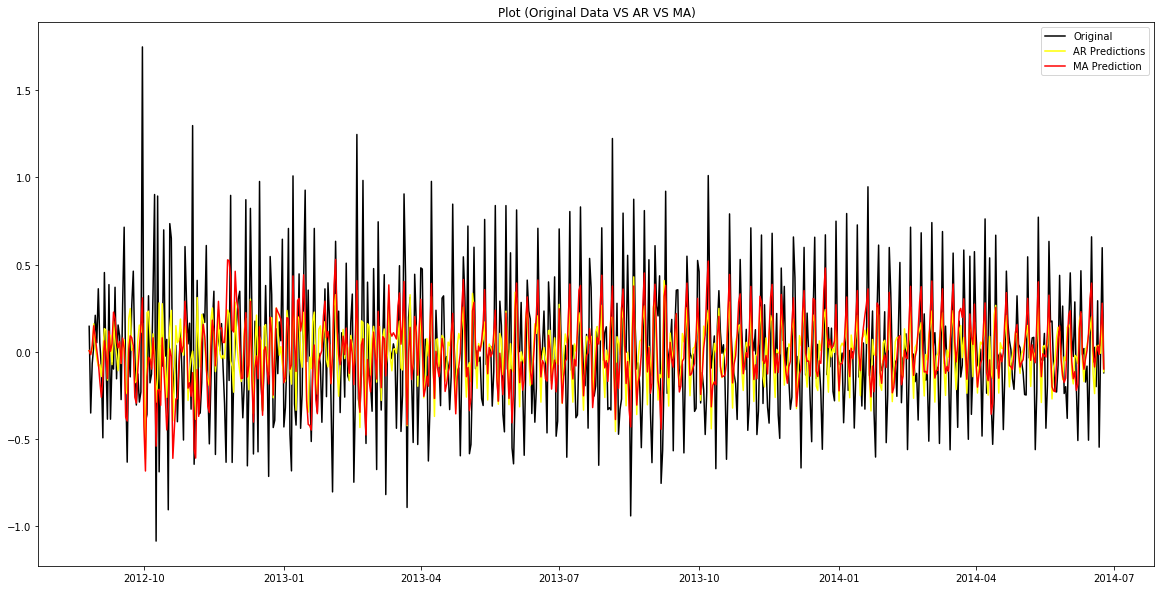

In [85]:
# Original VS AR VS MA comparison

plt.figure(figsize = (20, 10))
plt.plot(train_log_diff.dropna(), color = 'black', label = 'Original')
plt.plot(results_AR.fittedvalues, color = 'yellow', label = 'AR Predictions')
plt.plot(results_MA.fittedvalues, color = 'red', label = "MA Prediction")
plt.legend(loc = 'best')
plt.title('Plot (Original Data VS AR VS MA)')
plt.show()

#### MA VS AR Curve Comparison

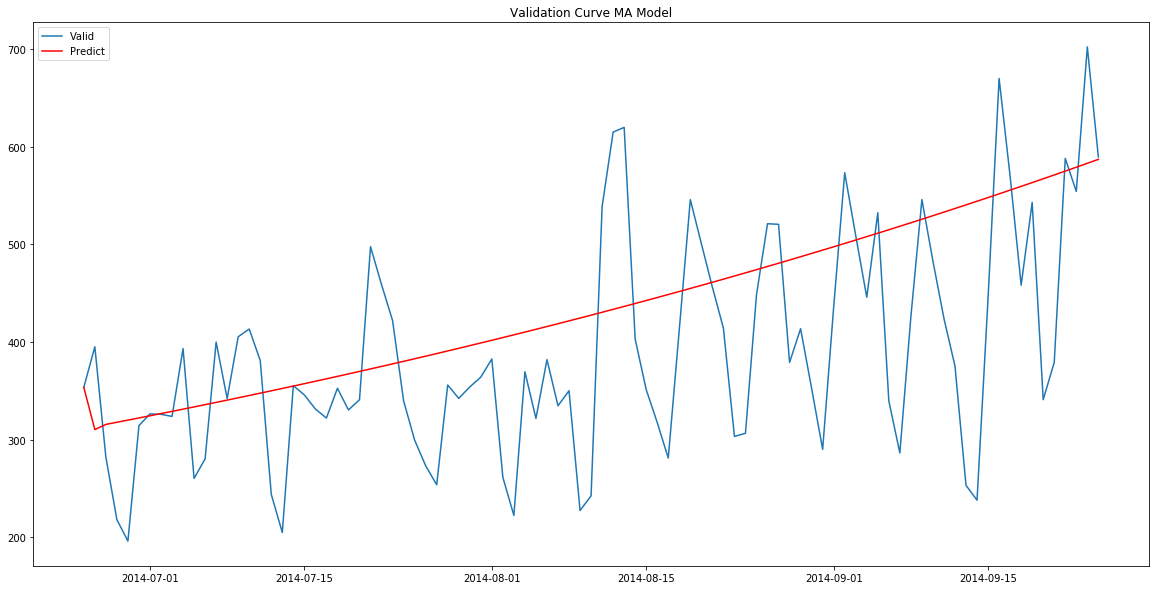

RMSE : 43.26967067134726


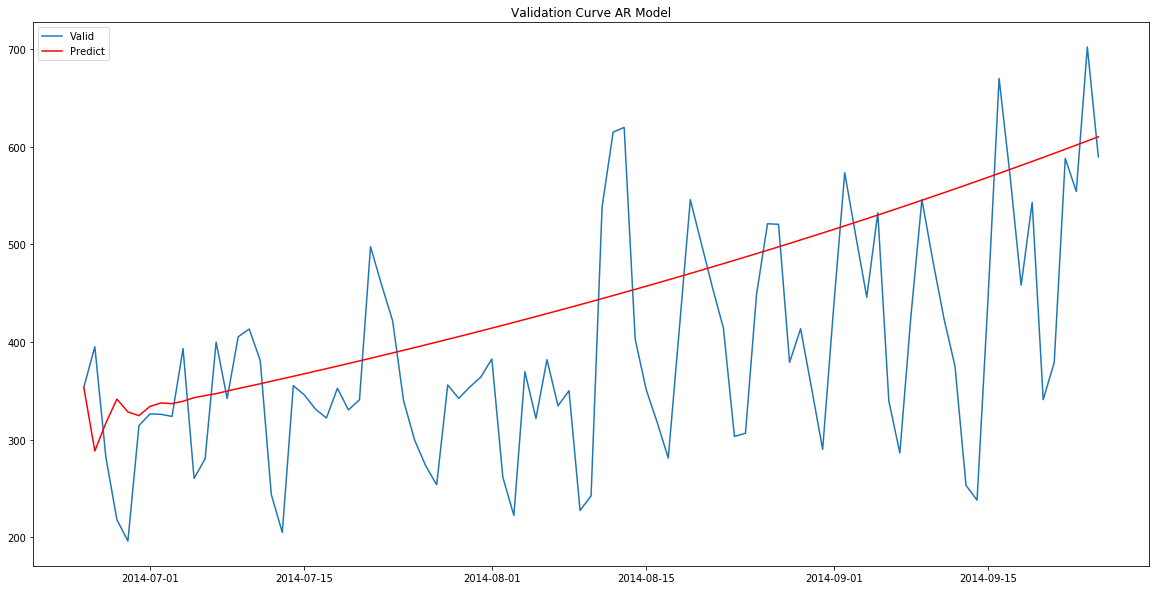

RMSE : 43.9740004094476


In [86]:
MA_predict = results_MA.predict(start = '2014-06-25', 
                                   end = '2014-09-25')
MA_predict = MA_predict.cumsum().shift().fillna(0)

MA_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
MA_predict1 = MA_predict1.add(MA_predict, fill_value = 0)
MA_predict = np.exp(MA_predict1)

plt.figure(figsize = (20, 10))
plt.plot(valid['Count'], label = 'Valid')
plt.plot(MA_predict, color = 'red', label = 'Predict')
plt.legend(loc = 'best')
plt.title('Validation Curve MA Model')
plt.show()

print('RMSE : {}'.format(np.sqrt(np.dot(MA_predict, valid['Count'])) / valid.shape[0]))

AR_predict = results_AR.predict(start = '2014-06-25', 
                               end = '2014-09-25')
AR_predict = AR_predict.cumsum().shift().fillna(0)

AR_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
AR_predict1 = AR_predict1.add(AR_predict, fill_value = 0)
AR_predict = np.exp(AR_predict1)

plt.figure(figsize = (20, 10))
plt.plot(valid['Count'], label = 'Valid')
plt.plot(AR_predict, color = 'red', label = 'Predict')
plt.legend(loc = 'best')
plt.title('Validation Curve AR Model')
plt.show()

print('RMSE : {}'.format(np.sqrt(np.dot(AR_predict, valid['Count'])) / valid.shape[0]))

#### Combined Model (ARIMA)

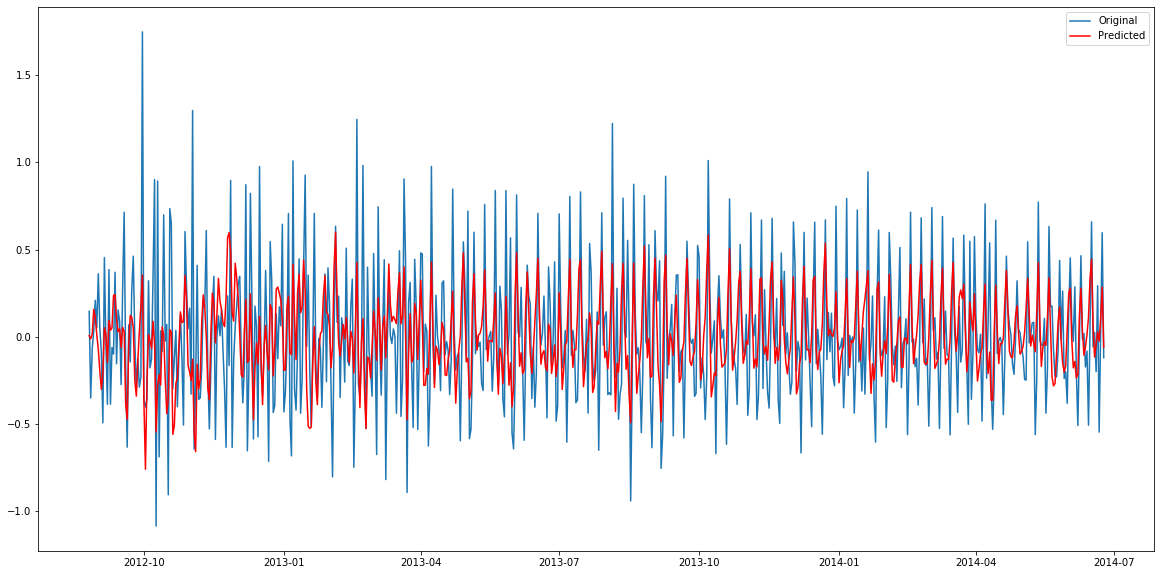

In [87]:
# ARIMA model 

ARIMA_model = ARIMA(Train_log, order = (2, 1, 2))
results_ARIMA = ARIMA_model.fit(disp = -1)

plt.figure(figsize = (20, 10))
plt.plot(train_log_diff.dropna(), label = 'Original')
plt.plot(results_ARIMA.fittedvalues, color = 'red', label = 'Predicted')
plt.legend(loc = 'best')
plt.show()

In [88]:
# Define function can be used to change the scale of the model
# to the original scale

def check_predict_diff(predict_diff, given_set):
    predict_diff = predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    
    predict_log = predict_base.add(predict_diff, fill_value = 0)
    predict = np.exp(predict_log)
    
    plt.figure(figsize = (20, 10))
    plt.plot(given_set['Count'], label = 'Given Set')
    plt.plot(predict, color = 'red', label = 'Predict')
    plt.legend(loc = 'best')
    plt.title('RMSE : {}'.format((np.sqrt(np.dot(predict, given_set['Count']))/ given_set.shape[0])))
    plt.show()

In [89]:
def check_predict_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = 'Given Set')
    plt.plot(predict, color = 'red', label = 'Predict')
    plt.legend(loc = 'best')
    plt.title('RMSE : %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))
                             / given_set[0]))
    plt.show()

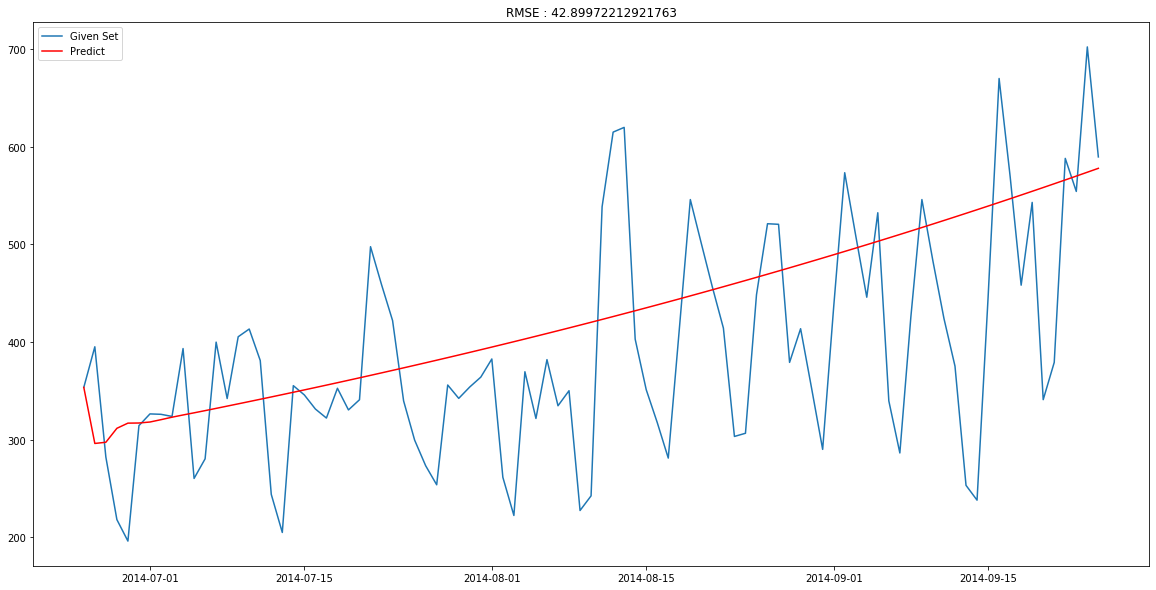

In [90]:
# Predict the values for validation set

ARIMA_predict_diff = results_ARIMA.predict(start = '2014-06-25', 
                                           end = '2014-09-25')

check_predict_diff(ARIMA_predict_diff, valid)

### SARIMAX

In [92]:
y_hat_avg = valid.copy()

In [93]:
fit1 = sm.tsa.statespace.SARIMAX(Train['Count'], order = (2, 1, 4), seasonal_order = (0, 1, 1, 7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start = '2014-6-25', end = '2014-9-25', dynamic = True)

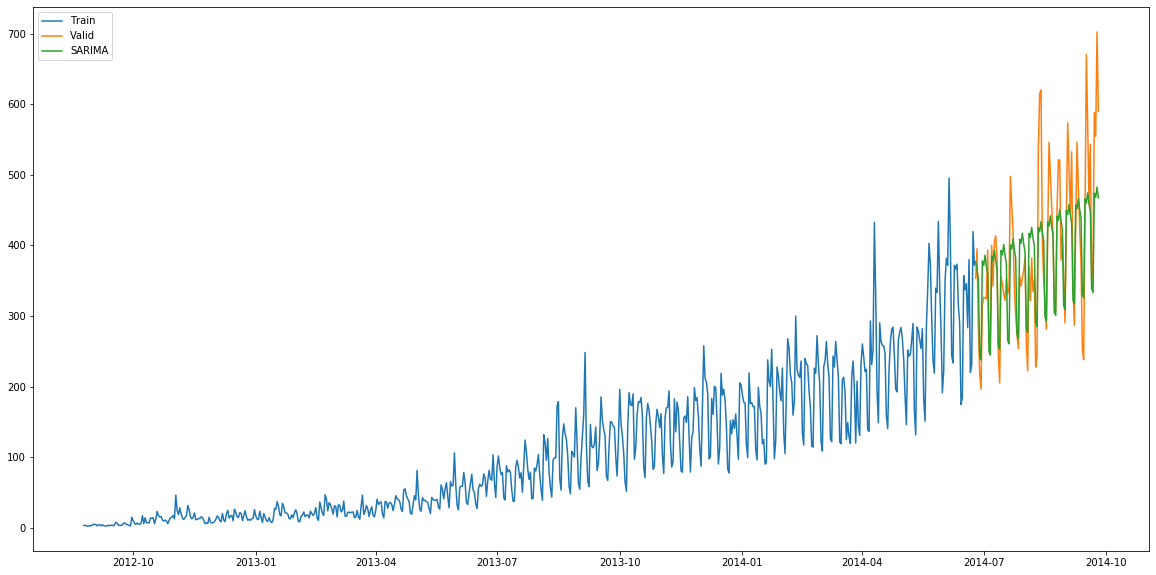

In [95]:
plt.figure(figsize = (20, 10))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['SARIMA'], label = 'SARIMA')
plt.legend(loc = 'best')
plt.show()

In [96]:
# RMSE checking

rmse_SARIMA = sqrt(mean_squared_error(valid['Count'], y_hat_avg['SARIMA']))
print('RMSE SARIMA : {}'.format(rmse_SARIMA))

RMSE SARIMA : 69.67242279085332


In [97]:
# Predicting Test data 2014-9-26 until 2015-4-26

predict_Test = fit1.predict(start = '2014-9-26', end = '2015-4-26', dynamic = True)

In [102]:
test['prediction'] = predict_Test

In [105]:
# Merging Test and test_original on day, month and year

merge = pd.merge(test, test_original, on = ('Day', 'Month', 'Year'), how = 'left')
merge['Hour'] = merge['Hour_y']
merge

,ID_x,Year,Month,Day,Hour_x,prediction,ID_y,Datetime,Hour_y,Hour
0,18299.5,2014.0,9.0,26.0,11.5,455.338660,18288,2014-09-26 00:00:00,0,0
1,18299.5,2014.0,9.0,26.0,11.5,455.338660,18289,2014-09-26 01:00:00,1,1
2,18299.5,2014.0,9.0,26.0,11.5,455.338660,18290,2014-09-26 02:00:00,2,2
3,18299.5,2014.0,9.0,26.0,11.5,455.338660,18291,2014-09-26 03:00:00,3,3
4,18299.5,2014.0,9.0,26.0,11.5,455.338660,18292,2014-09-26 04:00:00,4,4
...,...,...,...,...,...,...,...,...,...,...
5107,23387.5,2015.0,4.0,26.0,11.5,585.630027,23395,2015-04-26 19:00:00,19,19
5108,23387.5,2015.0,4.0,26.0,11.5,585.630027,23396,2015-04-26 20:00:00,20,20
5109,23387.5,2015.0,4.0,26.0,11.5,585.630027,23397,2015-04-26 21:00:00,21,21
5110,23387.5,2015.0,4.0,26.0,11.5,585.630027,23398,2015-04-26 22:00:00,22,22


In [107]:
merge = merge.drop(['Year', 'Month', 'Datetime', 'Hour_x', 'Hour_y'], axis = 1)
merge

,ID_x,Day,prediction,ID_y,Hour
0,18299.5,26.0,455.338660,18288,0
1,18299.5,26.0,455.338660,18289,1
2,18299.5,26.0,455.338660,18290,2
3,18299.5,26.0,455.338660,18291,3
4,18299.5,26.0,455.338660,18292,4
...,...,...,...,...,...
5107,23387.5,26.0,585.630027,23395,19
5108,23387.5,26.0,585.630027,23396,20
5109,23387.5,26.0,585.630027,23397,21
5110,23387.5,26.0,585.630027,23398,22


In [108]:
# Predicting by merging merge and temp2

prediction = pd.merge(merge, temp2, on = 'Hour', how = 'left')
prediction

,ID_x,Day,prediction,ID_y,Hour,ratio
0,18299.5,26.0,455.338660,18288,0,0.044287
1,18299.5,26.0,455.338660,18289,1,0.035343
2,18299.5,26.0,455.338660,18290,2,0.029911
3,18299.5,26.0,455.338660,18291,3,0.024714
4,18299.5,26.0,455.338660,18292,4,0.020802
...,...,...,...,...,...,...
5107,23387.5,26.0,585.630027,23395,19,0.055627
5108,23387.5,26.0,585.630027,23396,20,0.053455
5109,23387.5,26.0,585.630027,23397,21,0.049895
5110,23387.5,26.0,585.630027,23398,22,0.050076


In [112]:
# Converting the ratio to the original scale

prediction['Count'] = prediction['prediction'] * prediction['ratio'] * 24

In [114]:
# Drop all variables other than ID and Count

submission = prediction.drop(['Day', 'Hour', 'ratio', 'prediction', 'ID_x', 'ID_y'], axis = 1)

In [117]:
# Converting the final submission to csv format

pd.DataFrame(submission, columns=['ID', 'Count']).to_csv('SARIMAX.csv')

In [120]:
# RMSE checking

rmse_SARIMAX = sqrt(mean_squared_error(valid['Count'], predict_Test))
print('RMSE SARIMAX : {}'.format(rmse_SARIMAX))

ValueError: Found input variables with inconsistent numbers of samples: [93, 213]

In [123]:
valid['Count']

Datetime
2014-06-25    353.666667
2014-06-26    395.250000
2014-06-27    282.333333
2014-06-28    218.250000
2014-06-29    196.250000
                 ...    
2014-09-21    379.250000
2014-09-22    588.166667
2014-09-23    554.333333
2014-09-24    702.333333
2014-09-25    589.666667
Freq: D, Name: Count, Length: 93, dtype: float64

In [124]:
predict_Test

2014-09-26    455.338660
2014-09-27    346.994039
2014-09-28    341.721856
2014-09-29    481.895572
2014-09-30    476.056308
                 ...    
2015-04-22    726.304334
2015-04-23    711.185180
2015-04-24    699.246823
2015-04-25    590.902293
2015-04-26    585.630027
Freq: D, Length: 213, dtype: float64

### RMSE Comparison

In [135]:
rmse_scores = []
for rmse_models_score in [rmse, rmse_10, rmse_30, rmse_50, rms_SES, rms_holt, rms_holt_winter, rmse_SARIMA]:
    rmse_scores.append(rmse_models_score)

scores_df = pd.DataFrame({'MODEL': ['Naive Approach', 
                                    'Moving Average 10 Observations', 
                                    'Moving Average 30 Observations', 
                                    'Moving Average 50 Observations',
                                    'Simple Exponential Smoothing', 
                                    "Holt's Linear Model", 
                                    "Holt's Winter Model",
                                    'SARIMA'], 'SCORE': rmse_scores})

scores_df

,MODEL,SCORE
0,Naive Approach,111.790505
1,Moving Average 10 Observations,134.237333
2,Moving Average 30 Observations,129.649581
3,Moving Average 50 Observations,144.191757
4,Simple Exponential Smoothing,113.437081
5,Holt's Linear Model,112.942783
6,Holt's Winter Model,82.380412
7,SARIMA,69.672423
